In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

(0, 1)

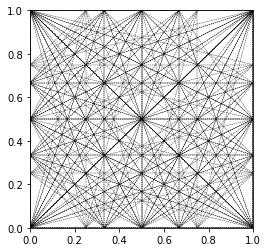

In [2]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy


plt.figure(figsize=(4,4))
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')

plt.xlim((0,1))
plt.ylim((0,1))

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
betx = 1.9065054393933862
alfx = 1.408226172730429
Nturn = np.array([128,256,512,1024,2048])
ChaosPercent = 99.0
iTBT = {}
TBT = {}
TBT_Inv = {}
X = {}
Y = {}
Npt = {}

NL_c = lattice[3].transverse_scale_c
x0 = betx**0.5*NL_c
x0 = np.array([-x0,x0])
y0 = [0,0]

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
print(x0)

[-0.01380763  0.01380763]


In [5]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [6]:
for nturn in Nturn:
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    dummy,TBT_Inv[nturn] = impact.readTBT_integral(nturn)
    dum1,dum2,Npt[nturn] = TBT[nturn].shape
    print(TBT[nturn].shape)

(128, 6, 6194)
(128, 6, 6066)
(256, 6, 5907)
(512, 6, 5746)
(1024, 6, 5528)


In [7]:
pData = impact.readParticleData(-111110,ke,mass,freq)
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)
print(np.min(pData[:,0]))

-0.003545926661239748


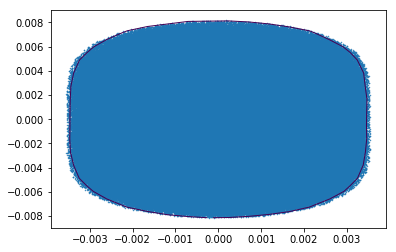

In [8]:
plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,linestyles='solid',levels=[1450])
plt.scatter(pData[:,0],pData[:,2],s=0.2)

In [9]:
def findSameIndex(table1,index1,table2,index2):
    for i in range(len(table2)-index2+1):
        #print(index1,index2,table1[index1],table2[index2],table1[index1]==table2[index2])
        if table1[index1] == table2[index2]:
            return index2
        else:
            index2 = index2+1
    print('max_reached,index1,index2=',index1,index2,len(table1),len(table2),table1[index1],table2[index2])

In [10]:
i=0
for nturn in Nturn[1:]:
    i=i+1
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    X[nturn][Nturn[i-1]:nturn,:] = TBT[nturn][:,0,:] - 1j*TBT[nturn][:,1,:]
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn][Nturn[i-1]:nturn,:] = TBT[nturn][:,2,:] - 1j*TBT[nturn][:,3,:]
    for j in range(i):
        k=0
        if j==0:
            nturn0 = 0
        else:
            nturn0 = Nturn[j-1]
        for ipt in range(npt):
            k = findSameIndex(iTBT[nturn],ipt,iTBT[Nturn[j]],k)
            X[nturn][nturn0:Nturn[j],ipt] = TBT[Nturn[j]][:,0,k] - 1j*TBT[Nturn[j]][:,1,k]
            Y[nturn][nturn0:Nturn[j],ipt] = TBT[Nturn[j]][:,2,k] - 1j*TBT[Nturn[j]][:,3,k]
#         print(i,j,nturn0,Nturn[j],nturn)

In [11]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}
XdiffLog = {}
YdiffLog = {}
AdiffLog = {}
XdiffSig = {}
YdiffSig = {}
AdiffSig = {}

for nturn in Nturn[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,X[nturn][:int(nturn/2),i],window_id=1)
        tune,amp,dummy = impact.util.naff(3,X[nturn][int(nturn/2):,i],window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,Y[nturn][:int(nturn/2),i],window_id=1)
        tune,amp,dummy = impact.util.naff(3,Y[nturn][int(nturn/2):,i],window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    AdiffLog[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    XdiffLog[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    YdiffLog[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    AdiffSig[nturn] = 1.0/(1.0+np.exp(-AdiffLog[nturn]+np.percentile(AdiffLog[nturn],ChaosPercent)))
    XdiffSig[nturn] = 1.0/(1.0+np.exp(-XdiffLog[nturn]+np.percentile(XdiffLog[nturn],ChaosPercent)))
    YdiffSig[nturn] = 1.0/(1.0+np.exp(-YdiffLog[nturn]+np.percentile(YdiffLog[nturn],ChaosPercent)))
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

In [12]:
test=np.sort(Adiff[2048])
print(test[-int(len(Adiff[2048])*0.01):])

[0.03846926 0.03875223 0.03888125 0.04188279 0.04242742 0.04378474
 0.04383789 0.0449025  0.04509447 0.04750085 0.04900889 0.05091717
 0.05411106 0.05736852 0.05737682 0.05958582 0.05988651 0.06215767
 0.06244331 0.06621251 0.07016853 0.07938876 0.09183352 0.11033138
 0.1151038  0.12021954 0.12168749 0.13704664 0.15095557 0.15804601
 0.15926828 0.15946682 0.16017022 0.16203653 0.16354167 0.16426264
 0.16433954 0.17465405 0.17578789 0.17657829 0.17927784 0.1811873
 0.18382754 0.18451837 0.18569118 0.18577423 0.18639862 0.18698234
 0.18711885 0.18780071 0.18782987 0.20503763 0.22804966 0.24915354
 0.47663684]


# plot

### FFT

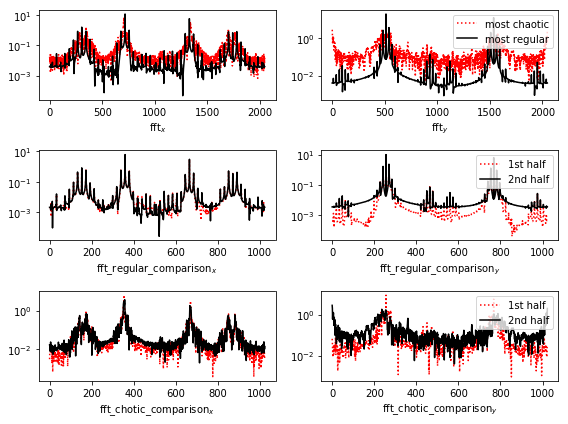

In [13]:
n=2048
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMin[n][1]])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMin[n][2]])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMin[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMin[n][1]])),'k')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMin[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMin[n][2]])),'k')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMax[n][1]])),'k')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMax[n][2]])),'k')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.png',dpi=180)
# plt.close()

##### fft of p at center

2.0594539984448987e-08 0.0002865179656947743 0.47663683821168545


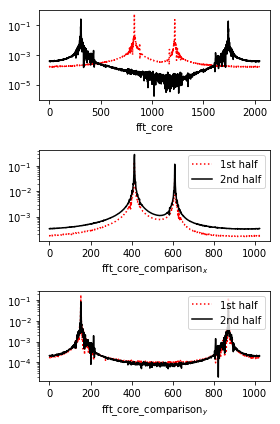

In [14]:
n=2048;
iptCore=np.argmin(np.abs(X[n][0,:])*np.abs(X[n][0,:])+np.abs(Y[n][0,:])*np.abs(Y[n][0,:]))

plt.figure(figsize=[4,6])
plt.subplot(3,1,1)
plt.semilogy(np.abs(np.fft.fft(X[n][:,iptCore])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iptCore])),'k')
plt.xlabel('fft_core')
plt.subplot(3,1,2)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iptCore])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iptCore])),'k')
plt.xlabel('fft_core_comparison$_x$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,1,3)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iptCore])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iptCore])),'k')
plt.xlabel('fft_core_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
# plt.close()

print(Adiff[n][iMin[n][0]],Adiff[n][iptCore],Adiff[n][iMax[n][0]])

### tune plot

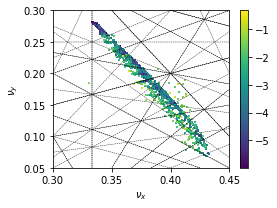

In [15]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=AdiffLog[n],s=1.0,marker='s')
    
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.A.png',dpi=180)
# plt.close()

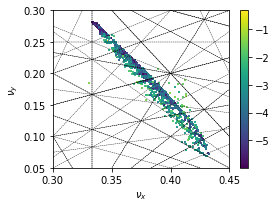

In [16]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=XdiffLog[n],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.X.png',dpi=180)
# plt.close()

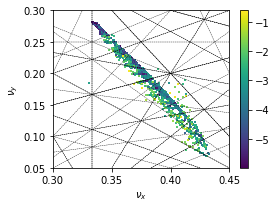

In [17]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=YdiffLog[n],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.Y.png',dpi=180)
# plt.close()

### Poincare

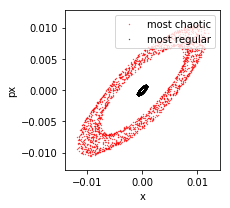

In [17]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.A.png',dpi=180)

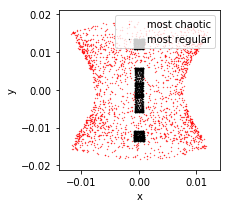

In [18]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.X.png',dpi=180)

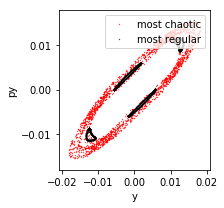

In [19]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.Y.png',dpi=180)

### Dynamic Aperture (Abs)

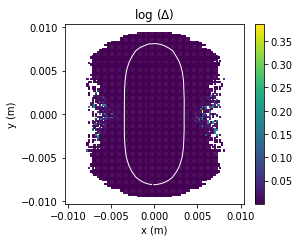

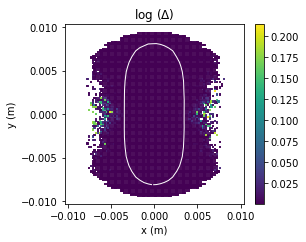

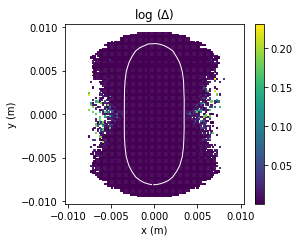

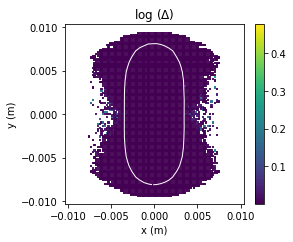

In [20]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('FMA.DA.Abs.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (Sigmoid)

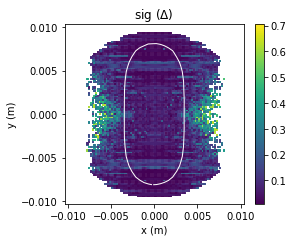

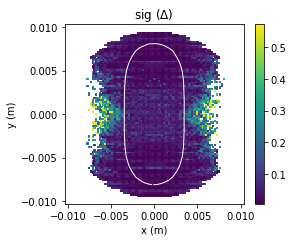

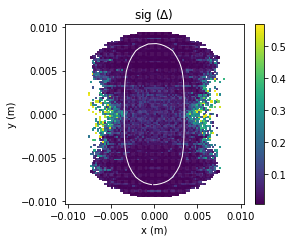

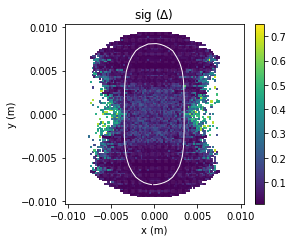

In [21]:
Adiff = AdiffSig
Xdiff = XdiffSig
Ydiff = YdiffSig

for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'sig ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('FMA.DA.Sig.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (Log)

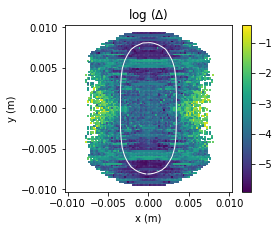

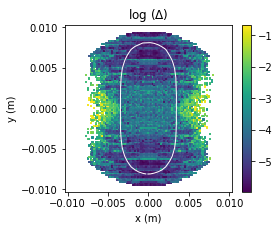

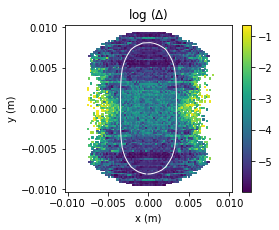

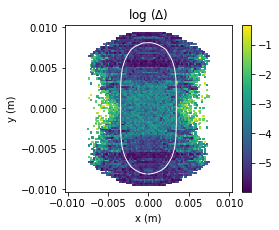

In [22]:
Adiff = AdiffLog
Xdiff = XdiffLog
Ydiff = YdiffLog

for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.tight_layout()
    plt.savefig('FMA.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

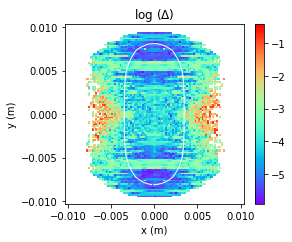

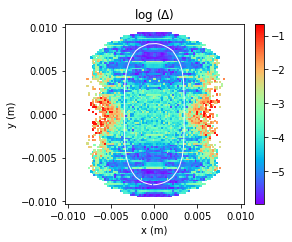

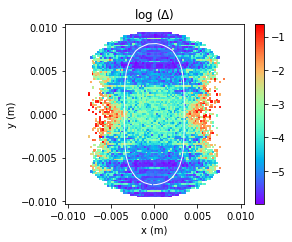

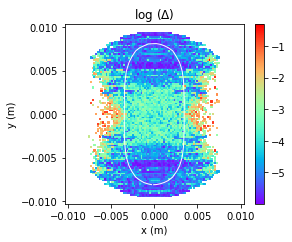

In [22]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s',cmap=cmap)
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('FMA.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

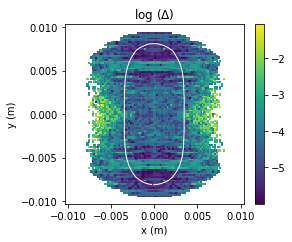

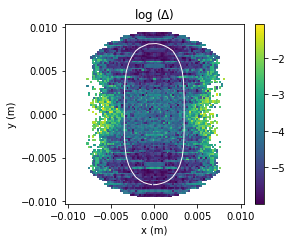

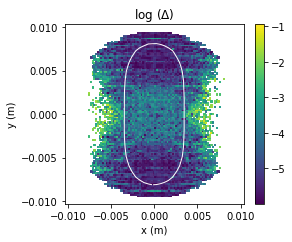

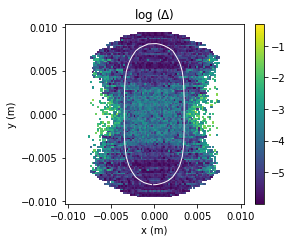

In [23]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Xdiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][1]]),np.real(Y[n][0,iMax[n][1]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('FMA.DA.Log.X.'+str(nturn)+'.png',dpi=180)

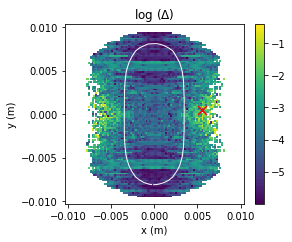

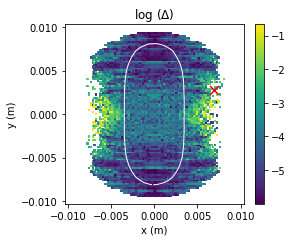

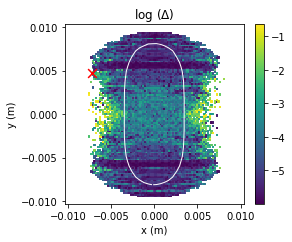

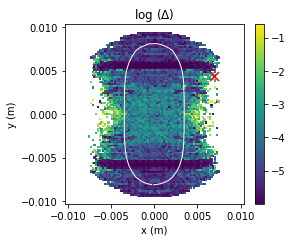

In [24]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Ydiff[n],s=1.6,marker='s')
    plt.scatter(np.real(X[n][0,iMax[n][2]]),np.real(Y[n][0,iMax[n][2]]),c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('FMA.DA.Log.Y.'+str(nturn)+'.png',dpi=180)

### Invariants

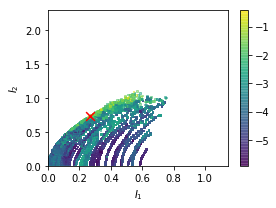

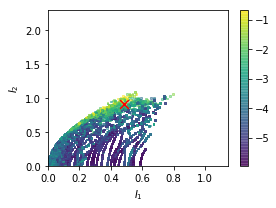

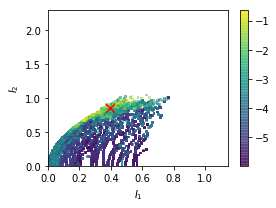

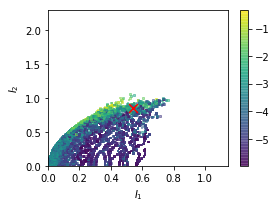

In [25]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3])
    f1=plt.scatter(TBT_Inv[n][0,0,:],TBT_Inv[n][0,1,:],c=Adiff[n],s=3.0,marker='s',alpha=0.5)
    plt.scatter(TBT_Inv[n][0,0,iMax[n][0]],TBT_Inv[n][0,1,iMax[n][0]],c='r',s=77,marker='x')
    plt.xlim(0,1.15)
    plt.ylim(0,2.3)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('FMA.Int.Log.A.'+str(nturn)+'.png',dpi=180)